In [49]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Neural Net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [33]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
df=pd.read_csv("/content/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [51]:
df.dropna(axis=0, inplace=True)
df.info()

# convert categorical variable into dummy variables
df = pd.get_dummies(df, columns=['ocean_proximity'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude              

In [52]:
# our target variable is 'median_house_value'
y = df['median_house_value']
X = df.drop('median_house_value', axis=1)
print(X.shape, y.shape)

# convert to numpy array
X = np.array(X)
y = np.array(y)

# split into X_train and X_test
# always split into X_train, X_test first THEN apply minmax scaler
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# use minMax scaler
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

(20433, 13) (20433,)
(16346, 13) (4087, 13) (16346,) (4087,)


In [54]:
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

# compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=50,
                    batch_size=50,
                    verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1000)              14000     
                                                                 
 dense_17 (Dense)            (None, 500)               500500    
                                                                 
 dense_18 (Dense)            (None, 250)               125250    
                                                                 
 dense_19 (Dense)            (None, 1)                 251       
                                                                 
Total params: 640001 (2.44 MB)
Trainable params: 640001 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
327/327 [==============================] - 9s 22ms/step - loss: 22730682368.0000 - mae: 113536.8516 - val_loss: 8138075648.0000 - val_mae: 

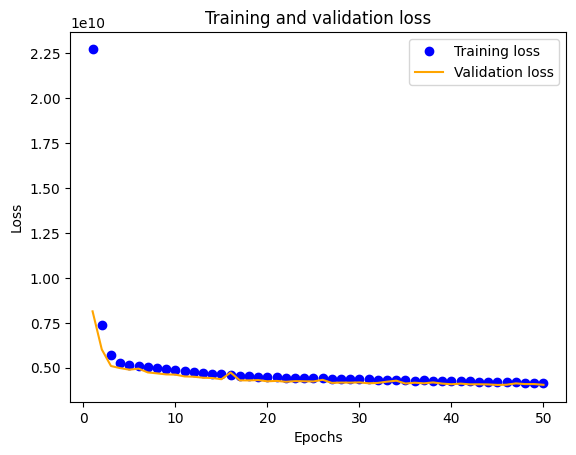

In [55]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

128/128 [==============================] - 0s 3ms/step


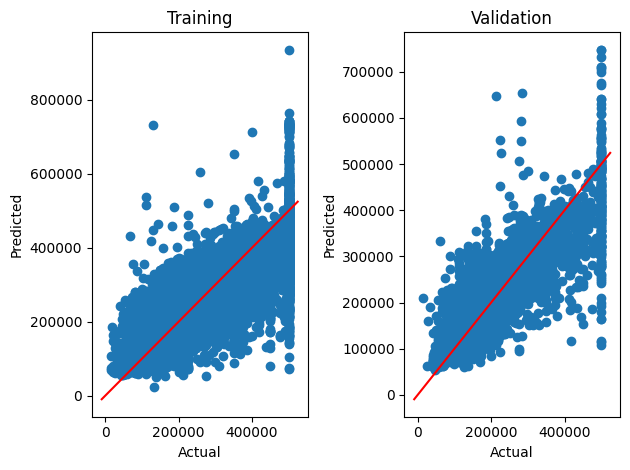

In [56]:
# scatterplot of actual vs. pred
# specify the dimensions
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [57]:
pred = model.predict(X_test)
pred

trainpreds = model.predict(X_train)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, trainpreds)) # train
print(mean_absolute_error(y_test, pred)) # test

511/511 [==============================] - 2s 3ms/step
45718.62173443618
44976.426347068445


<b>Drop out

In [58]:
from keras.layers import Dense, Dropout

# Insert the dropout layer
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1000)              14000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_21 (Dense)            (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_22 (Dense)            (None, 250)               125250    
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                